In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#/// Import useful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from scipy.stats import norm 
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.integrate import quad

# STATISTICAL INFERENCE FOR A DARK MATTER SEARCH
You will reproduce a direct detection experiment searching for WIMP dark matter with a dual-phase TPC (a simplified version of XENON1T). 

Targets of the excercise:

- [ ] Build a **2D physical model** for the expected signal and backgrounds 
- Given a (simulated) dataset, compute the **exclusion limit** on the WIMP cross section using 
    - [ ] the simple **Likelihood Ratio method**
    - [ ] and the **Profile Likelihood Ratio method** introducing nuisance parameters. 
- [ ] Estimate the **expected experimental sensitivity**
- [ ] (Optional extra) Estimate the **expected discovery potential** with 3$\sigma$ significance and test your dataset for **discovery** (and eventually set a confidence interval on the WIMP cross section).
- [ ] (Optional extra) Study the sensitivity as a function of background expected **rate** and **uncertainty**
- [ ] (Optional extra) Study the sensitivity as a function of **exposure**

# 1. BUILD THE PHYSICAL MODEL

We follow a simplified version of the physical model adopted for the XENON experiments. The oservable signals produced by an interaction are S1 and S2.

We can distinguish two types of interactions (electronic recoils, **ERs** and nuclear recoils, **NRs**) which produce very different S2/S1 ratios (much larger for ERs). Therefore one can exploit a parameter based on the S2/S1 ratio to separate and discriminate ERs from NRs. The WIMP signal is expected to be of NR type.

We use a 2D analysis space:
- **S1 signal** (unit: PE, photoelectrons) | The primary scintillation signal in a TPC. It is a proxy for event energy
- **Y discrimination parameter** | The "flattened" $\log_{10}$(S2/S1). A parameter for which electronic (ER) and nuclear recoils (NR) are well separated.

For this WIMP search we fix:
- The **region of interest** (RoI) for this WIMP search as the interval **(3,70) PE in the S1 space**.
- The fiducial target mass as **1000 kg**
- The data taking livetime as **2 years**
- ... thus the **exposure** is $2\,t\,y$ (mass $\times$ livetime)

Signal and background models:
- **Signal**: WIMP of 50 GeV/c$^2$ mass 
- **Backgrounds**
    - *ER background*: sum of external (e.g. gammas from detector materials, neutrinos) and intrinsic sources (e.g. Rn222, Kr85) 
    - *NR background*: sum of neutron (mainly radiogenic neutrons from materials) and neutrino sources (CE$\nu$NS mainly from solar neutrinos)
    
We need to model signal and backgrounds in the 2D space (S1, Y). Therefore we need:
- Probability density functions (**PDF**s) in S1 and Y
- **Expectation values** ($\mu$), i.e. expected number of events

## 1.1 S1 PDFs
We provide you with the expected S1 spectra that you can find in the [GitHub repo](https://github.com/pietrodigangi/SoUP2021-InferenceExercise) of the execrise: 
- WIMP (50 GeV/c2 mass) signal: `Sig-WIMP-50-S1.txt`
- ER background: `Bkg-ER-S1.txt`
- NR background: `Bkg-NR-S1.txt`

Units: x (S1 signal, PE), y (spectrum, a.u.)

Tasks:
- [ ] Read input files
- [ ] Interpolate the (binned) spectra
- [ ] Normalize to PDFs in the RoI (3,70) PE
- [ ] Visualize S1 spectra and PDFs

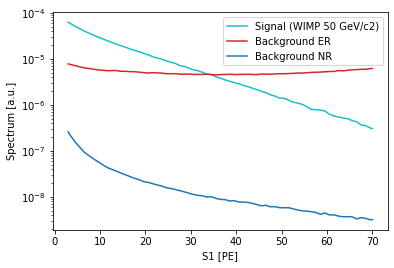

In [3]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Read input spectra for signal and backgrounds
#/////////////////////////////////////////////////////////////////////////////////////////////////

# Read signal and background S1 spectra
signal = pd.read_csv('Sig-WIMP-50-S1.txt', sep=' ')
backgroundER = pd.read_csv('Bkg-ER-S1.txt', sep=' ')
backgroundNR = pd.read_csv('Bkg-NR-S1.txt', sep=' ')

# Interpolate binned data
f_signal = interp1d(signal.S1, signal.spectrum)
f_backgroundER = interp1d(backgroundER.S1, backgroundER.spectrum)
f_backgroundNR = interp1d(backgroundNR.S1, backgroundNR.spectrum)

# Visualize spectra
fig, ax = plt.subplots(1, 1)
x = np.linspace(3,70,1000)
ax.plot(x, f_signal(x)*1e-5, 'b-', color='tab:cyan', label='Signal (WIMP 50 GeV/c2)')
ax.plot(x, f_backgroundER(x), color='tab:red', label='Background ER')
ax.plot(x, f_backgroundNR(x), color='tab:blue', label='Background NR')
plt.xlabel('S1 [PE]')
plt.ylabel('Spectrum [a.u.]')
plt.yscale('log')
plt.legend()
plt.show()

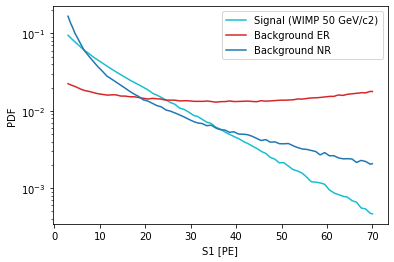

In [4]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Signal and background PDFs (S1)
#/////////////////////////////////////////////////////////////////////////////////////////////////

def normalize2pdf(func, xmin=3, xmax=70):
    '''
    Return a PDF (distribution normalized to 1)
    in the interval (xmin,xmax)
    '''
    stepsize = 0.01
    #xmin = 3
    #xmax = 70
    
    # compute the integral of original distribution
    integral = 0
    for x in np.arange(xmin+0.5*stepsize, xmax-0.5*stepsize, stepsize):
        integral += func(x)*stepsize
    #print(integral)
    
    pdf = lambda x : func(x)/integral
    return pdf

#print(quad(f_signal,3,70))
pdf_signal = normalize2pdf(f_signal)
#print(quad(pdf_signal,3,70))

#print(quad(f_backgroundER,3,70))
pdf_backgroundER = normalize2pdf(f_backgroundER)
#print(quad(pdf_backgroundER,3,70))

#print(quad(f_backgroundNR,3,70))
pdf_backgroundNR = normalize2pdf(f_backgroundNR)
#print(quad(pdf_backgroundNR,3,70))

# Visualize PDFs
fig, ax = plt.subplots(1, 1)
x = np.linspace(3,70,1000)
ax.plot(x, pdf_signal(x), 'b-', color='tab:cyan', label='Signal (WIMP 50 GeV/c2)')
ax.plot(x, pdf_backgroundER(x), color='tab:red', label='Background ER')
ax.plot(x, pdf_backgroundNR(x), color='tab:blue', label='Background NR')
plt.xlabel('S1 [PE]')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()
plt.show()

## 1.2 PDFs in discrimination space (Y)

To reproduce a typical ER discrimination power of 99.5% (with 50% NR acceptance) in LXe dual-phase TPCs, we assume that ERs and NRs are distributed in an idealized **discrimination parameter Y** as *Gaussian* with the following mean and standard deviation:
- ER: `mean=0`, `std=1`
- NR: `mean=-2.58`, `std=0.92`

Our model components are of type:
- WIMP signal is expected to be of **NR** type
- **ER** background
- **NR** background


Tasks:
- [ ] Define the two Gaussian PDFs for ER and NR (that will be properly associated to signal (NR) and backgrounds as PDFs in the Y space).
- [ ] Visualize such PDFs in the Y space

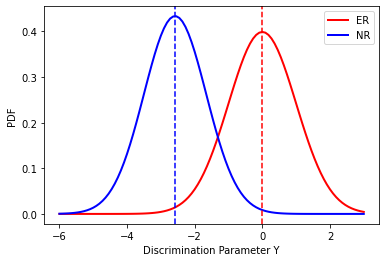

In [5]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Discrimination space (Y)
#/////////////////////////////////////////////////////////////////////////////////////////////////

# ER and NR distributions
er_discr = norm()
nr_discr = norm(loc=-2.58, scale=0.92)
# This reproduces the following separation between ER and NR populations:
# 99.5% ER rejection with 50% NR acceptance

# Visualize PDFs
fig, ax = plt.subplots()
fig.figsize = (16,8)
x = np.linspace(-6,3,100)
ax.plot(x, er_discr.pdf(x), 'r-', lw=2, label='ER')
ax.plot(x, nr_discr.pdf(x), 'b-', lw=2, label='NR')
plt.axvline(-2.58, ls='--', color='b')
plt.axvline(0, ls='--', color='r')
plt.xlabel('Discrimination Parameter Y')
plt.ylabel('PDF')
plt.legend()
plt.show()

## 1.3 Rates and expectation values

We assume the following rates for signal and backgrounds in the S1 RoI (3, 70) PE:
- WIMP signal: `2.68 events/t/y` (corresponding to a WIMP cross section = $1.0\times10^{-47}$ cm$^2$)
- ER background: `61.98 events/t/y`
- NR background: `2.01 events/t/y`

Note #1: We are using here rates vaguely similar to those expected in the XENON1T experiment in the core 1 t fiducial volume. One usually estimates and predict the signal and backgrounds in the recoil energy space (keV); then you need to apply the detector response model (to ERs and NRs) to convert recoil energy into observable S1 (and S2) signals. (This goes beyond the scope of this excercise, therefore we directly work in the S1 space, with the spectra provided in section 1.1)

Note #2: WIMP rate is based on standard DM halo assumptions and WIMP-nucleon spin-independent coupling for a LXe target. You can easily convert number of signal events $n_{sig}$ into **WIMP cross section**: $\sigma=\frac{n_{sig}}{rate_{sig}\times exposure} \times 10^{-47} \ cm^2$

Note #3: The ER background rate is reduced compared to XENON1T (just to make the following computations less intensive and time consuming)

Task:
- [ ] Calculate the **expectation values** (no. of expected events) in the fixed exposure of 2 ty: $\mu_{sig}$ (signal), $\mu_{bkgER}$ (ER background), $\mu_{bkgNR}$ (NR background) 

In [6]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Rates and expectation values
#/////////////////////////////////////////////////////////////////////////////////////////////////

# Region of Interest (S1 ROI)
S1min = 3   #PE
S1max = 70  #PE
RoI = S1max - S1min

# Rates 
# Expected number of events in the S1 ROI 
# per unit energy (or better S1 signal amplitude)
# per unit target mass 
# per unit time
rate_sig   = 0.04 #(/PE/t/y) # 50 GeV/c2 WIMP with cross section = 1.0e-47 cm2
rate_bkgER = 1.85 / 2  #(/PE/t/y)
rate_bkgNR = 0.03  #(/PE/t/y)

# Exposure
mass     = 1.0 #tonnes
livetime = 2.0 #years
exposure = mass * livetime

def nsig2xs(nsig, exp = exposure):
    '''
    Converts no. of signal events into cross section
    given a benchmark rate of 0.04 events/PE/t/y
    for a cross section of 1.0e-47 cm2
    
    Returns a cross section scaling factor
    with respect to the benchmark 1.0e-47 cm2
    '''
    xs = nsig/(rate_sig * exp * RoI)
    return xs

#/// Expectation values
mu_sig   = rate_sig * exposure * RoI
mu_bkgER = rate_bkgER * exposure * RoI
mu_bkgNR = rate_bkgNR * exposure * RoI

print('/// Expectation values in the S1 RoI (%.0f,%.0f) PE and %.1f ty exposure' % (S1min, S1max, exposure))
print('Signal:', mu_sig, '(50 GeV WIMP with cross section = 1.0e-47 cm2)')
print('Background ER:', mu_bkgER)
print('Background NR:', mu_bkgNR)

/// Expectation values in the S1 RoI (3,70) PE and 2.0 ty exposure
Signal: 5.36 (50 GeV WIMP with cross section = 1.0e-47 cm2)
Background ER: 123.95
Background NR: 4.02


## 1.4 Toy-Dataset random generator
You can simulate "observed" data based on your statistical model. A simulated dataset is usually called toy-MC, toy-dataset or pseudo-experiment.

Tasks:

- [ ] Write a routine to generate random datasets in the 2D space (S1,Y) based on the signal/background PDFs and expectation values. For each model component you need:
    - Poissonian random generation of **number of events** (given the expectation value $\mu$)
    - For each event, random sampling of **S1** and **Y** (given the S1 and Y PDFs) 
- [ ] Try out one toy-dataset generation, visualize events in the 2D space, compare the outcome with the expectation values and distributions 

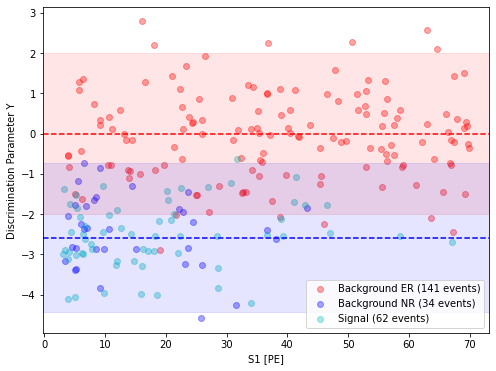

In [7]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Toy Dataset Generator (in 2D space: S1,Y)
#/////////////////////////////////////////////////////////////////////////////////////////////////
def random_sampling_pdf(x0,x1,pdf,size):
    '''
    Random sampling based on custom PDF
    x0   : x lower bound
    x1   : x upper bound
    pdf  : custom function normalized to 1
    size : number of events to generate
    '''
    sample=[]
    nLoop=0
    while len(sample)<size:
        x=np.random.uniform(low=x0,high=x1)
        prob=pdf(x)
        assert prob>=0 and prob<=1
        if np.random.uniform(low=0,high=1) <= prob:
            sample.append(x)
        nLoop+=1 
    return sample

def generate_subset(S1_pdf, Y_pdf, size):
    '''
    Returns a Pandas dataframe with random generated events
    S1_pdf : pdf_signal, pdf_backgroundER or pdf_backgroundNR
    Y_pdf  : er_discr or nr_discr
    size   : number of events
    '''
    S1s = random_sampling_pdf(3,70,S1_pdf,size)
    Ys  = Y_pdf.rvs(size=size)
    dict = {'S1': S1s, 'Y': Ys}
    df = pd.DataFrame(dict)
    return df


#/// Quick example ////////////////////////////////////////////////////////////////////////////////////////////
#/// Number of events (Poisson generation)
n_sig   = np.random.poisson(mu_sig * 10) # enhance no. of signal events (just to visualize it better) 
n_bkgER = np.random.poisson(mu_bkgER)
n_bkgNR = np.random.poisson(mu_bkgNR * 10) # enhance no. of background NR events (just to visualize it better) 

#/// Dataset generation
dataset_sig   = generate_subset(pdf_signal,nr_discr,n_sig)
dataset_bkgER = generate_subset(pdf_backgroundER,er_discr,n_bkgER)
dataset_bkgNR = generate_subset(pdf_backgroundNR,nr_discr,n_bkgNR)
dataset = pd.DataFrame()
dataset = dataset.append([dataset_sig, dataset_bkgER, dataset_bkgNR]) # toy experiment

# Plot dataset
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(dataset_bkgER.S1, dataset_bkgER.Y, color='r', alpha=0.35, label='Background ER (%d events)' % n_bkgER)
ax.scatter(dataset_bkgNR.S1, dataset_bkgNR.Y, color='b', alpha=0.35, label='Background NR (%d events)' % n_bkgNR)
ax.scatter(dataset_sig.S1, dataset_sig.Y, color='c', alpha=0.35, label='Signal (%d events)' % n_sig)
# draw Y distributions (median and 2 sigma band)
plt.axhspan(-2, 2, color='r', alpha=0.1)
plt.axhline(0, ls='--', color='r')
plt.axhspan(-2.58-2*0.92, -2.58+2*0.92, color='b', alpha=0.1)
plt.axhline(-2.58, ls='--', color='b')

plt.xlabel('S1 [PE]')
plt.ylabel('Discrimination Parameter Y')
plt.legend() 
plt.show()
#/// Quick example ////////////////////////////////////////////////////////////////////////////////////////////


def generate_toy_dataset(mu_sig, mu_bkgER=mu_bkgER, mu_bkgNR=mu_bkgNR, plot=False):
    '''
    Returns
    dataset : a dataframe of generated events (Toy experiment)
    subsets : list of dataframes for signal, background ER and NR
    '''
    n_sig   = np.random.poisson(mu_sig) 
    n_bkgER = np.random.poisson(mu_bkgER)
    n_bkgNR = np.random.poisson(mu_bkgNR)
    #print('No. generated events:', n_sig, '(signal)', n_bkgER, '(bkgER)', n_bkgNR, '(bkgNR)')

    #/// Dataset generation
    dataset_sig   = generate_subset(pdf_signal,nr_discr,n_sig)
    dataset_bkgER = generate_subset(pdf_backgroundER,er_discr,n_bkgER)
    dataset_bkgNR = generate_subset(pdf_backgroundNR,nr_discr,n_bkgNR)
    subsets = [dataset_sig, dataset_bkgER, dataset_bkgNR]
    dataset = pd.DataFrame()
    dataset = dataset.append(subsets) # toy experiment
    
    if plot:
        plot_toy_dataset(subsets, mu_sig)
    
    return dataset, subsets

def plot_toy_dataset(subsets, mu_sig=None):
    '''
    Plotting a toy dataset in 2D space (S1, Y)
    '''
    dataset_sig = subsets[0]
    dataset_bkgER = subsets[1]
    dataset_bkgNR = subsets[2]
    n_sig = len(dataset_sig)
    n_bkgER = len(dataset_bkgER)
    n_bkgNR = len(dataset_bkgNR)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot()
    ax.scatter(dataset_bkgER.S1, dataset_bkgER.Y, color='r', alpha=0.35, label='Background ER (%d)' % n_bkgER)
    ax.scatter(dataset_bkgNR.S1, dataset_bkgNR.Y, color='b', alpha=0.35, label='Background NR (%d)' % n_bkgNR)
    ax.scatter(dataset_sig.S1, dataset_sig.Y, color='c', alpha=0.75, label='Signal (%d)' % n_sig, s=100)
    # draw Y distributions (median and 2 sigma band)
    #plt.axhspan(-2, 2, color='r', alpha=0.1)
    plt.axhline(0, ls='--', color='r')
    #plt.axhspan(-2.58-2*0.92, -2.58+2*0.92, color='b', alpha=0.1)
    plt.axhline(-2.58, ls='--', color='b')
    plt.title('Signal expectation value µ_sig = %.1f (µ_ER=%.1f, µ_NR=%.1f)' % (mu_sig, mu_bkgER, mu_bkgNR))

    plt.xlabel('S1 [PE]')
    plt.ylabel('Discrimination Parameter Y')
    plt.legend(title='Generated events') 
    plt.show()

# 2. STATISTICAL INFERENCE WITH THE LIKELIHOOD RATIO METHOD (Exclusion limit)

Possible hypotheses at play:
- Signal hypotheses $H_\mu$ (as a function of the *signal strength* $\mu_{sig}$): signal exists with an expectation value $\mu = \mu_{sig}$.
- Null (background-only) hypothesis $H_0$: signal does not exists, i.e. $\mu=0$.

**Parameter of interest** (PoI): WIMP cross section $\sigma$ (or equivalently the signal strength $\mu_{sig}$, just a linear transformation between them.)

**Inference for signal exclusion:** you want to test signal hypotheses $H_\mu$ and evaluate the significance of their *rejection* based on the observed data.

**Exclusion limit at 90% CL:** The WIMP cross section (or signal strength $\mu_{sig}$) at which the signal hypothesis ($H_{\mu}$) is rejected with 90% CL, i.e. the probability to get a larger disagreement between the observed data and the signal hypothesis (observed p-value) is 1-CL = 0.1. 

To evaluate how well (or not) your physical model fits the observed data you need to:
- define the **Likelihood function** $L(\mu_{sig})$
- fit data (via log-likelihood minimization) and find the **maximum likelihood estimator** (MLE) of the PoI: $\hat{\mu}_{sig}$

To compute the significance (i.e. the **p-value**) of the rejection of a given signal hypothesis $H_{\mu}$, we use the **Likelihood Ratio test statistic** ($q_{\mu}$) and we need to know what is the expected distribution (**PDF**) of the test statistic under such signal hypothesis $f(q_{\mu}|H_\mu)$.

For searches of rare events, one needs to estimate $f(q_{\mu}|H_\mu)$ for each $\mu_{sig}$ to be tested via toy-MC: random generation of many pseudo-experiments (toy dataset) and evaluate $q_{\mu}$ on each of them. The required statistic is $>10^{3-4}$ toy-MCs. This is quite computationally expensive, therefore we provide you with already estimated $f(q_{\mu}|H_\mu)$ for $\mu_{sig}$ for the following signal strengths: `mu_set = [0.1,1,5,9,13,15,19]`.


Task: 
- [ ] Given a dataset, perform the statistical inference using the **Likelihood Ratio method** to derive the exclusion limit on the WIMP cross section at 90% confidence level (CL). For that you need to:
    - [ ] Fix the dataset: Read the already produced dataset available in the excercise repo: `example_dataset_0.pkl` or generate a toy-dataset (imposing $\mu_{sig}=0$)
    - [ ] Write the likelihood function $L(\mu_{sig})$
    - [ ] Fit your dataset, find $\hat{\mu}_{sig}$, plot the log-likelihood curve vs $\mu_{sig}$
    - [ ] Write the Likelihood Ratio test statistic ($q_{\mu}$)
    - [ ] Compute the value of the test statistic $q_{\mu}$ for the given dataset for different signal strengths $\mu_{sig}$ (in `mu_set`) and
    - [ ] compute the associated **p-value** based on the test statistic PDF under the signal hypothesis $f(q_{\mu}|H_\mu)$
    - [ ] Find $\mu_{sig}$ at which p-value = 0.1 (this is your limit at 90% CL!)
    - [ ] Convert the limit from number of events into cross section

## 2.1 Likelihood function

We use the *extended unbinned likelihood function*:
\begin{equation} \label{eq:likelihood_LR}
L(\mu_{sig}) = \frac{\mu_{tot}^{N_{obs}}}{N_{obs}!} \, e^{-\mu_{tot}} \, \prod^{N_{obs}}_{i=1}P(S1_i,Y_i) = \frac{e^{-\mu_{tot}}}{N_{obs}!} \,   \prod^{N_{obs}}_{i=1} \mu_{tot} \, P(S1_i,Y_i) \: ,
\end{equation}

where 
- $N_{obs}$ is the total number of observed events, 
- $\mu_{tot} = \mu_{sig} + \mu_{bkgER} + \mu_{bkgNR}$, 

and

\begin{split}
P(S1_i,Y_i) = & \, \frac{1}{\mu_{tot}}\big[\mu_{sig} \, f_{sig}(S1_i) \, g_{NR}(Y_i) + \mu_{bkgER} \, f_{bkgER}(S1_i) \, g_{ER}(Y_i) + \mu_{bkgNR} \, f_{bkgNR}(S1_i) \, g_{NR}(Y_i)\big] \: ,         
\end{split}

with $f_{x}$ is the S1 PDF of the model component $x$ (sig, bkgER or bkgNR), $g_{k}$ is the Y PDF ($k$ stands for ER or NR).


**It is useful to work with $-2\log L$, which for our statistical model takes the form:**
\begin{equation}
\begin{split}
-2 \, \log \,  L(\mu_{sig}) & = 2 \, \mu_{tot} -2 \, \sum_{i=1}^{N_{obs}} \log \big[\mu_{tot} \, P(S1_i,Y_i) \big] \\
                             & = 2 \, (\mu_{sig}+\mu_{bkgER}+\mu_{bkgNR}) -2 \, \sum_{i=1}^{N_{obs}} \log \big[\mu_{sig} \, f_{sig}(S1_i) \, g_{NR}(Y_i) \\
                             & \quad +\mu_{bkgER} \, f_{bkgER}(S1_i) \, g_{ER}(Y_i) + \mu_{bkgNR} \, f_{bkgNR}(S1_i) \, g_{NR}(Y_i)\big] \: .
\end{split}
\label{eq:log-l_LR}
\end{equation}

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood function definition
#/////////////////////////////////////////////////////////////////////////////////////////////////
# Tip: define -2 log-likelihood
# Tip: define a function which takes a single argument (array); this is useful at the minimization stage
# Tip: exploit a global variable "dataset" to run over events in the dataset; 
# you don't want to pass data as an argument to the likelihood function (again this is useful at the minimization stage)

#-> your code here <-

### 2.1.1 Likelihood curve vs $\mu_{sig}$ and the MLE $\hat{\mu}$
For a given dataset:
- perform a likelihood fit of data (minimize $-2\log L(\mu_{sig})$), i.e. find the maximum likelihood estimator $\hat{\mu_{sig}}$, 
- plot $-2\log L(\mu_{sig})$ for a resonable range of $\mu_{sig}$ (e.g. (-10,20)) and 
- check that $-2\log L(\hat{\mu}_{sig})$ is its minimum value (or conversely $L(\hat{\mu}_{sig})$ is the *maximum likelihood*)

Try with a randomly generated toy-dataset by yourself or use the **example dataset** available in the excercise repository: it is a dataframe stored in the file `example_dataset_0.pkl`.

In [ ]:
#/// Read the dataset
!pip install pickle5
import pickle5 as pickle
with open('example_dataset_0.pkl',"rb") as fh:
  dataset = pickle.load(fh)
# dataset = pd.read_pickle('example_dataset_0.pkl')

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood fit on an example toy-experiment dataset
#/////////////////////////////////////////////////////////////////////////////////////////////////
# Tip: You can use minimize from scipy.optimize

#-> your code here <-

## 2.2 Test statistic: Likelihood ratio $q_\mu$

The likelihood ratio test statistic for signal exclusion $q_\mu$ is defined as:

\begin{equation} \label{eq:test_stat_cases}
q_\mu =
\begin{cases}
-2 \, \log \frac{L(\mu_{sig})}{L(\hat{\mu}_{sig})} & \text{if } \hat{\mu}_{sig} \leq \mu_{sig} \\
0                                               & \text{if } \hat{\mu}_{sig} > \mu_{sig} \: .
\end{cases}
\end{equation}  

Increasing values of $q_\mu$ indicate larger discrepancy between the tested signal hypothesis, i.e. signal strength $\mu_{sig}$, and the observed data (which show the best agreement with $\hat{\mu}_{sig}$).

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood ratio test statistic (for signal hypotesis rejection)
#/////////////////////////////////////////////////////////////////////////////////////////////////

#-> your code here <-

### 2.2.1 Test statistic PDF under signal hypotheses: $f(q_\mu|H_\mu)$

You can generate O(1k) or more toy-datasets under given signal strenghts $\mu_{sig}$ and collect the values of $q_\mu$ for each dataset and build the PDF $f(q_\mu|H_\mu)$.

Sensible range of $\mu_{sig}$ is about (1, 20), for our physical model. The generation of 1 toy-MC and likelihood minimization can take ~1 or few seconds (you can check by yourself, and maybe try speed this up). Hence the generation of O(1k) times several $\mu_{sig}$ hypotheses can take several hours.

You can retrieve already produced test statistic distributions $f(q_\mu|H_\mu)$ from the pickle file `test_stat_distributions_blessed.pkl` for some $\mu_{sig}$.

In [ ]:
#/// Read test statistic dataframes from file and checkout its structure

#-> your code here <-

Write a routine to compute $f(q_\mu|H_\mu)$ by yourself, if you want to try out...

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Test statistic distribution under a given signal hypothesis: mu_sig
#/////////////////////////////////////////////////////////////////////////////////////////////////
# Tip: define a global varable "dataset" and assign each generated dataset to it
# so that the likelihood function will refer to it

#-> your code here <-

## 2.3 p-value calculation

The p-value of a given dataset realization for the rejection of a signal hypothesis $\mu$ is given by

\begin{equation}
p_\mu = \int_{q_\mu^{obs}}^{\infty} f(q_\mu|H_\mu) \, \text{d}q_\mu \: ,
\end{equation}

where $q_\mu^{obs}$ is the test statistic value (testing the signal strength $\mu$) calculated on the given dataset.

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Compute p-value
#/////////////////////////////////////////////////////////////////////////////////////////////////

#-> your code here <-

Checkout the test statistic distribution for a given $\mu_{sig}$ and compute the p-value for a given $q_{\mu}$ value...

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Plot f(qmu|Hmu) 
#///(optional) show a given q value and the corresponding p-value) 
#/////////////////////////////////////////////////////////////////////////////////////////////////

#-> your code here <-

## 2.4 Exclusion limit at 90% CL

For the dataset used previously, compute the exclusion p-value for signal hypotheses approximately in the range $\mu_{sig}$ = (1, 20) and find the value of $\mu_{sig}$ for which p-value = 0.1 (90% CL): $\mu_{sig}^{limit}$. 

Convert $\mu_{sig}^{limit}$ into WIMP cross section... that's your 90% CL exclusion limit on the WIMP-nucleon spin-independent coupling for WIMPs of mass 50 GeV/c2.

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Compute exclusion limit for a single toy-experiment
#/////////////////////////////////////////////////////////////////////////////////////////////////

#-> your code here <-

# 3. INFERENCE WITH THE PROFILE LIKELIHOOD RATIO (Exclusion limit)

Now we introduce **systematic uncertainty** on the expected background rates:
- $\sigma_{bkgER}$ = 40% | uncertainty on ER background
- $\sigma_{bkgNR}$ = 50% | uncertainty on NR background

To take uncertainties into account, we need to include **nuisance parameters** $(t_{bkgER}, t_{bkgNR})$ in the likelihood function $L(\mu_{sig};t_{bkgER}, t_{bkgNR})$ that rescale the background expectation values as
- $\mu_{bkgER}(t_{bkgER}) = \mu_{bkgER} * (1 + t_{bkgER} * \sigma_{bkgER})$
- $\mu_{bkgNR}(t_{bkgNR}) = \mu_{bkgNR} * (1 + t_{bkgNR} * \sigma_{bkgNR})$



We now use the **Profile Likelihood Ratio** as **test statistic** for the rejection of signal hypotheses:

\begin{equation}
q_\mu=
\begin{cases}
-2 \, \log \, \frac{L(\mu , \, \hat{\hat{\boldsymbol{\theta}}}(\mu))}{L(\hat{\mu} , \, \hat{\boldsymbol{\theta}})} & \hat{\mu} \leq \mu\\[1.5ex]
0 & \hat{\mu} > \mu \: ,
\end{cases}
\end{equation}

where $\boldsymbol{\theta} = (t_{bkgER}, t_{bkgNR})$ and $\mu$ simply stands for $\mu_{sig}$.

This requires two different likelihood fits on data:
- **Unconditional fit** | where we find the MLE of the parameter of interest and nuisance parameters that maximize the likelihood function, i.e. $L(\hat\mu, \hat{t}_{bkgER}, \hat{t}_{bkgNR})$
- **Conditional fit** | where $\mu_{sig}$ is fixed at the signal strength under test, thus one computes the conditional maximum likelihood $L(\mu; \hat{\hat{t}}_{bkgER}, \hat{\hat{t}}_{bkgNR})$

Tasks:
- [ ] Write the Likelihood function (now depending also on $t_{bkgER}$ and $t_{bkgNR}$)
- [ ] Write the Profile Likelihood Ratio test statistic
- [ ] With the same dataset, compute the observed test statistic value,
- [ ] compute the p-value for different tested signal strengths $\mu_{sig}$
- [ ] Find the limit at 90% CL
- [ ] Compare with the exclusion limit found with the simple Likelihood Ratio method

## 3.1 Nuisance parameters

We translate our systematic uncertainty on background rates by introducing nuisance parameters and assuming *Gaussian constraints* for them. Hence they follow a normal distribution. The $\sigma_{bkg}$ values correspond to a 1 sigma deviation from the nominal expectation value $\mu_{bkg}(t=0)$. 

Tip: fix a lower bound to the nuisance parameter values in order to avoid unphysical expectation values (<0). E.g. $t_{bkgER}^{min} = -1 / \sigma_{bkgER}$

## 3.2 Toy-Dataset generation with nuisance parameters

To generate toy-datasets we need to random sample also nuisance parameters, which affect the backgrounds expected number of events.

So, for both ER and NR background components, we first sample the nuisance parameter values, which we call $t^*_{bkgER}$ and $t^*_{bkgNR}$. Then compute the expectation value $\mu_{bkg}(t^*_{bkg})$ and generate the number of background events by the usual poissonian sampling based on $\mu_{bkg}(t^*_{bkg})$.

Tip: You want to record the generated $t^*$, so make sure you instantiate global variables accessible later on, outside the toy-dataset generator routine. For sensitivity studies, the gaussian penalty term in the likelihood function for the nuisance parameters will refer to $t^*$ as the nominal value, instead of 0.

## 3.3 Likelihood function $L(\mu_{sig}; t_{bkgER}, t_{bkgNR})$

Extend the definition of the likelihood function to add the dependency on the nuisance parameters.

- Background expectation values as a function of nuisance parameters
- Add the Gaussian penalty terms for the nuisance parameters that take the form $-\frac{(t-t^*)^2}{2}$

Hence $-2\log L$ can be expressed as:

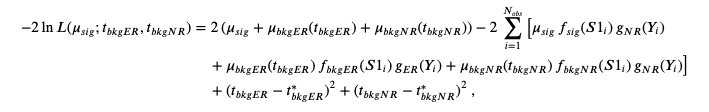

In [8]:
from IPython.display import Image
Image(filename='Likelihood_function.png')

where $t^*$ is the nominal value of the nuisance parameters ($t^*=0$ for hypothesis testing on observed data; $t^*$ given by each different toy-dataset random generation for sensitivity studies).

### 3.3.1 Unconditional and conditional MLE
For a given dataset perform both the unconditional and conditional likelihood fit of data. Try out the conditional fit for a given test $\mu_{sig}$ (e.g. =10).

Evaluate the log-likelihood curves in both cases.

## 3.4 Test statistic: Profile Likelihood Ratio
Write the profile likelihood ratio test statistic.

Tip: write a routine that, given $\mu_{sig}$, computes $q_{\mu}$ on a dataset, and that performs the conditional likelihood fit only when needed to optimize speed.

## 3.4.1 Test statistic PDF under $H_\mu$

You can retrieve already produced test statistic distributions $f(q_\mu|H_\mu)$ from the same pickle file `test_stat_distributions_blessed.pkl` for some $\mu_{sig}$.

## 3.5 Exclusion limit at 90% CL

Compute the 90% CL exclusion limit on your dataset.

# 4. SENSITIVITY WITH THE LIKELIHOOD RATIO METHOD
The sensitivity gives you the exclusion limit expected based on your experimental physical model. More precisely, to study the sensitivity you estimate the distribution of the expected exclusion limits (under the null hypothesis, no signal). Instead of computing the exclusion limit on a given dataset, now you want to simulate many datasets under the null hypothesis $H_0$ and estimate $f(q_\mu|H_0)$ for signal strengths $\mu_{sig}$ in the range of interest.

The median (1-2$\sigma$) sensitivity corresponds to the observed test statistic $q_{\mu}$ given by the median (1-2$\sigma$) quantile of $f(q_\mu|H_0)$.

## 4.1 Expected test statistic PDF under null hypothesis: $f(q_\mu|H_0)$
- Generate ~$10^4$ toy-MCs under the background-only hypothesis $H_0$ 
- Compute $q_\mu$ on each toy-MC for a set of signal strengths $\mu_{sig}$ and build $f(q_\mu|H_0)$

For a given $\mu_{sig}$ plot $f(q_\mu|H_0)$ vs $f(q_\mu|H_\mu)$

## 4.2 Median sensitivity
- Based on the median values of $f(q_\mu|H_0)$ for each $\mu$, find the limit at 90% CL


## 4.3 1 and 2 sigma bands
- Find the 90% CL limit corresponding to the $\pm1$ and $\pm2\sigma$ quantiles of $f(q_\mu|H_0)$ to find the 1 and 2$\sigma$ bands of the sensitivity


## 4.4 Exclusion limit outcome vs expected sensitivity
- Compare the exclusion limit obtained previously with the given dataset with the expected sensitivity (median and 1/2 sigma bands)


### 4.4.1 CL$_s$ or Power constraint
underfluctuations of background in the observed dataset can lead to strong exclusion limits on values of the PoI to which the experiment is poorly sensitive.

One solution is the CLs method:
Use a modified p-value

$p' = \frac{p}{1-p_b}$, where

$1 - p_b = \int^\inf_{q_{\mu}^{obs}}f(q_\mu|H_0) dq_\mu$

This method gives weaker limits but provides overcoverage, so it is conservative.

Another approach is the **Power constraint**, in which an experiment claims the $-1\sigma$ sensitivity as limit in case the actual limit is below that level.

# 5 Discovery significance and potential
In this case you want to test and reject the null hypothesis (instead of the signal hypotheses, as we did before to set exclusion limits). 

## 5.1 Test statistic for discovery
You can evaluate the significance of the rejection of the background-only hypothesis (which implies discovery!) by means of the **profile likelihood ratio test statistic for discovery** $q_0$:

\begin{equation}
q_0=
\begin{cases}
-2 \, \log \, \frac{L(0 , \, \hat{\hat{\boldsymbol{\theta}}}(0))}{L(\hat{\mu} , \, \hat{\boldsymbol{\theta}})} & \hat{\mu} \geq 0\\[1.5ex]
0 & \hat{\mu} < 0 \: ,
\end{cases}
\end{equation}



## 5.2 p-value (discovery significance)
If you evaluate $q_0$ on a given dataset and compare it with its PDF under the null hypothesis $H_0$ ($f(q_0|H_0)$, you can calculate the **p-value** exactly as you did before in the case of $H_\mu$ rejection.

Then the p-value is conventionally translated into significance $Z$, considering a one-sided normal distribution. If you consider the p-value as the one-sided integral of a normal distribution, $I=\int_{-\infty}^{Z}N(x)dx$, you have the 1:1 correspondence between p-value and $Z$ (p-value = $1-I$). Hence, e.g. $3\sigma$ significance corresponds to $Z=3$ -> $I=0.9987$ -> p-value = $1.3\times10^{-3}$.


## 5.3 Discovery potential
The expected discovery limit at $3\sigma$ significance (e.g.) is the minimum WIMP cross section (or the smallest signal strength $\mu_{sig}$) for which the null hypothesis $H_0$ is rejected with a significance of at least $3\sigma$. To estimate the expected discovery potential of an experiment, one has to simulate many toy-datasets and estimate the test statistic distribution under signal hypotheses $f(q_0|H_\mu)$ for a sensible range of $\mu_{sig}$. Then for each $\mu_{sig}$ you can consider the median of $f(q_0|H_\mu)$ and compute the p-value for $H_0$ rejection.

In the case of discovery one usually considers the 90% or 95% quantile of $f(q_0|H_\mu)$, instead of the median. That means the experimental discovery limit is xxx (what you find) with 90% probability (instead of with 50% probability, as in the case you consider the median).

As for the discovery significance one usually also considers $5\sigma$, besides $3\sigma$ (just conventions anyway...)